# Query Biothings Explorer's TRAPI endpoint for DrugMechDB concepts

In [3]:
# Builtin
import time
from pathlib import Path
from itertools import chain
from collections import defaultdict

# PIP
import demjson
import requests
import pandas as pd
import networkx as nx
from tqdm import tqdm
from matplotlib import pyplot as plt

# Github
from data_tools.plotting import venn2_pretty as venn2

/Users/hanbing/opt/anaconda3/lib/python3.9/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
this_name = '3_querying_bte_trapi'
out_dir = Path('../2_pipeline').joinpath(this_name, 'out').resolve()
out_dir.mkdir(exist_ok=True, parents=True)

data_dir = Path('../0_data/external').resolve()

In [7]:
import yaml
with open(data_dir.joinpath('indication_paths.yaml'), 'r') as fh:
        ind = yaml.load(fh, Loader=yaml.Loader)
        
dmdb_nodes = defaultdict(list)
for p in ind:
    for n in p['nodes']:
        for k in ['id', 'name', 'label']:
            # some strings have a unicode Byte order mark
            # let's just strip it for functionality
            dmdb_nodes[k].append(n[k].replace('\ufeff', ''))
dmdb_nodes = pd.DataFrame(dmdb_nodes)

## Compare metanodes in Biothings Explorer TRAPI to DMDB

In [10]:
dmdb_mn = set(dmdb_nodes['label'].unique())

In [13]:
# r = requests.get("https://api.bte.ncats.io/v1/predicates")
r = requests.get("https://api.bte.ncats.io/v1/meta_knowledge_graph")
metagraph = r.json()
bte_mn =  set([k.split(':')[-1] for k in metagraph.keys()])

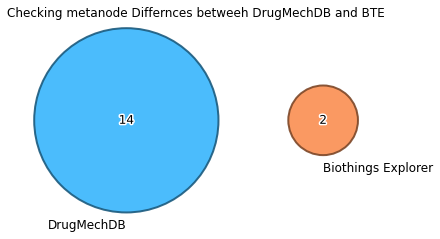

In [14]:
venn2([dmdb_mn, bte_mn], ('DrugMechDB', 'Biothings Explorer'))
plt.title('Checking metanode Differnces betweeh DrugMechDB and BTE');

A perfect Subset

In [16]:
def process_bte_result(result, hops=1):
    out = defaultdict(list)
    for res in result.json()['message']['results']:
        out['n0'].append(res['node_bindings']['n0'][0]['id'])
        for i in range(1, hops+1):
            out['e{0}{1}'.format(i-1, i)].append(res['edge_bindings']['e{0}{1}'.format(i-1, i)][0]['id'].split('-')[1])
            out['n{}'.format(i)].append(res['node_bindings']['n{}'.format(i)][0]['id'])
    return pd.DataFrame(out)

In [17]:
def get_response_ids(result):
    out_map = defaultdict(list)
    for k, v in r.json()['message']['knowledge_graph']['nodes'].items():
        for elem in v['attributes']:
            if elem.get('name') == 'equivalent_identifiers':
                for e in elem.get('value'):
                    out_map['bte_id'].append(k)
                    out_map['eqiv_id'].append(e)
    return pd.DataFrame(out_map)

In [18]:
# Taken from https://github.com/kevinxin90/biomedical_id_resolver.js/blob/master/src/config.ts
text = """
{
  Gene: {
    id_ranks: ['NCBIGENE', 'ENSEMBL', 'HGNC', 'SYMBOL', 'OMIM', 'UniProtKB', 'UMLS', 'MGI', 'name'],
    semantic: 'Gene',
    api_name: 'mygene.info',
    url: 'https://mygene.info/v3/query',
    mapping: {
      NCBIGENE: ['entrezgene'],
      name: ['name'],
      SYMBOL: ['symbol'],
      UMLS: ['umls.cui', 'umls.protein_cui'],
      HGNC: ['HGNC'],
      UniProtKB: ['uniprot.Swiss-Prot'],
      ENSEMBL: ['ensembl.gene'],
      OMIM: ['MIM'],
      MGI: ['MGI'],
    },
    additional_attributes_mapping: {
      interpro: ['interpro.desc'],
      type_of_gene: ['type_of_gene'],
    },
  },
  Protein: {
    id_ranks: ['UniProtKB', 'ENSEMBL', 'SYMBOL', 'UMLS', 'name'],
    semantic: 'Protein',
    api_name: 'mygene.info',
    url: 'https://mygene.info/v3/query',
    mapping: {
      name: ['name'],
      SYMBOL: ['symbol'],
      UMLS: ['umls.cui', 'umls.protein_cui'],
      UniProtKB: ['uniprot.Swiss-Prot'],
      ENSEMBL: ['ensembl.protein'],
    },
    additional_attributes_mapping: {
      interpro: ['interpro.desc']
    },
  },
  SequenceVariant: {
    id_ranks: ['HGVS', 'DBSNP', 'MYVARIANT_HG19', 'CLINVAR'],
    api_name: 'myvariant.info',
    semantic: 'SequenceVariant',
    url: 'https://myvariant.info/v1/query',
    mapping: {
      MYVARIANT_HG19: ['_id'],
      DBSNP: ['dbsnp.rsid', 'clinvar.rsid', 'dbnsfp.rsid'],
      HGVS: ['clinvar.hgvs.genomic', 'clinvar.hgvs.protein', 'clinvar.hgvs.coding'],
      ClINVAR: ['clinvar.rcv.accession'],
    },
    additional_attributes_mapping: {
      cadd_consequence: ['cadd.consequence'],
      cadd_variant_type: ['cadd.type'],
      dbsnp_variant_type: ['dbsnp.vartype'],
      clinvar_clinical_significance: ['clinvar.rcv.clinical_significance'],
      sift_category: ['cadd.sift.cat'],
    },
  },
  ChemicalSubstance: {
    id_ranks: [
      'CHEBI',
      'CHEMBL.COMPOUND',
      'DRUGBANK',
      'PUBCHEM.COMPOUND',
      'MESH',
      'INCHI',
      'INCHIKEY',
      'UNII',
      'KEGG',
      'UMLS',
      'name',
    ],
    semantic: 'ChemicalSubstance',
    api_name: 'mychem.info',
    url: 'https://mychem.info/v1/query',
    mapping: {
      'CHEMBL.COMPOUND': ['chembl.molecule_chembl_id', 'drugbank.xrefs.chembl', 'drugcentral.xrefs.chembl_id'],
      DRUGBANK: ['drugcentral.xrefs.drugbank_id', 'pharmgkb.xrefs.drugbank', 'chebi.xrefs.drugbank', 'drugbank.id'],
      'PUBCHEM.COMPOUND': [
        'pubchem.cid',
        'drugbank.xrefs.pubchem.cid',
        'drugcentral.xrefs.pubchem_cid',
        'pharmgkb.xrefs.pubchem.cid',
      ],
      CHEBI: ['chebi.id', 'chembl.chebi_par_id', 'drugbank.xrefs.chebi', 'drugcentral.xrefs.chebi'],
      UMLS: ['drugcentral.xrefs.umlscui', 'pharmgkb.xrefs.umls', 'umls.cui'],
      MESH: ['umls.mesh', 'drugcentral.xrefs.mesh_descriptor_ui', 'ginas.xrefs.MESH', 'pharmgkb.xrefs.mesh'],
      UNII: ['drugcentral.xrefs.unii', 'unii.unii', 'aeolus.unii', 'ginas.unii'],
      INCHIKEY: ['drugbank.inchi_key', 'ginas.inchikey', 'unii.inchikey', 'chebi.inchikey'],
      INCHI: ['drugbank.inchi', 'chebi.inchi', 'chembl.inchi'],
      KEGG: ['drugbank.xrefs.kegg.cid'],
      LINCS: ['unichem.lincs'],
      name: ['chembl.pref_name', 'drugbank.name', 'umls.name', 'ginas.preferred_name', 'pharmgkb.name', 'chebi.name'],
    },
    additional_attributes_mapping: {
      chembl_max_phase: ['chembl.max_phase'],
      chembl_molecule_type: ['chembl.molecule_type'],
      drugbank_drug_category: ['drugbank.categories.category'],
      drugbank_taxonomy_class: ['drugbank.taxonomy.class'],
      drugbank_groups: ['drugbank.groups'],
      drugbank_kingdom: ['drugbank.taxonomy.kingdom'],
      drugbank_superclass: ['drugbank.taxonomy.superclass'],
      contraindications: ['drugcentral.drug_use.contraindication.concept_name'],
      indications: ['drugcentral.drug_use.indication.concept_name'],
      mesh_pharmacology_class: ['drugcentral.pharmacology_class.mesh_pa.description'],
      fda_epc_pharmacology_class: ['drugcentral.pharmacology_class.fda_epc.description'],
    },
  },
  Drug: {
    id_ranks: [
      'CHEBI',
      'CHEMBL.COMPOUND',
      'DRUGBANK',
      'PUBCHEM.COMPOUND',
      'MESH',
      'INCHI',
      'INCHIKEY',
      'UNII',
      'KEGG',
      'UMLS',
      'LINCS',
      'name',
    ],
    semantic: 'ChemicalSubstance',
    api_name: 'mychem.info',
    url: 'https://mychem.info/v1/query',
    mapping: {
      'CHEMBL.COMPOUND': ['chembl.molecule_chembl_id', 'drugbank.xrefs.chembl', 'drugcentral.xrefs.chembl_id'],
      DRUGBANK: ['drugcentral.xrefs.drugbank_id', 'pharmgkb.xrefs.drugbank', 'chebi.xrefs.drugbank', 'drugbank.id'],
      'PUBCHEM.COMPOUND': [
        'pubchem.cid',
        'drugbank.xrefs.pubchem.cid',
        'drugcentral.xrefs.pubchem_cid',
        'pharmgkb.xrefs.pubchem.cid',
      ],
      CHEBI: ['chebi.id', 'chembl.chebi_par_id', 'drugbank.xrefs.chebi', 'drugcentral.xrefs.chebi'],
      UMLS: ['drugcentral.xrefs.umlscui', 'pharmgkb.xrefs.umls', 'umls.cui'],
      MESH: ['umls.mesh', 'drugcentral.xrefs.mesh_descriptor_ui', 'ginas.xrefs.MESH', 'pharmgkb.xrefs.mesh'],
      UNII: ['drugcentral.xrefs.unii', 'unii.unii', 'aeolus.unii', 'ginas.unii'],
      INCHIKEY: ['drugbank.inchi_key', 'ginas.inchikey', 'unii.inchikey', 'chebi.inchikey'],
      INCHI: ['drugbank.inchi', 'chebi.inchi', 'chembl.inchi'],
      KEGG: ['drugbank.xrefs.kegg.cid'],
      name: ['chembl.pref_name', 'drugbank.name', 'umls.name', 'ginas.preferred_name', 'pharmgkb.name', 'chebi.name'],
    },
    additional_attributes_mapping: {
      chembl_max_phase: ['chembl.max_phase'],
      chembl_molecule_type: ['chembl.molecule_type'],
      drugbank_drug_category: ['drugbank.categories.category'],
      drugbank_taxonomy_class: ['drugbank.taxonomy.class'],
      drugbank_groups: ['drugbank.groups'],
      drugbank_kingdom: ['drugbank.taxonomy.kingdom'],
      drugbank_superclass: ['drugbank.taxonomy.superclass'],
      contraindications: ['drugcentral.drug_use.contraindication.concept_name'],
      indications: ['drugcentral.drug_use.indication.concept_name'],
      mesh_pharmacology_class: ['drugcentral.pharmacology_class.mesh_pa.description'],
      fda_epc_pharmacology_class: ['drugcentral.pharmacology_class.fda_epc.description'],
    },
  },
  PhenotypicFeature: {
    id_ranks: ['UMLS', 'SNOMEDCT', 'HP', 'MEDDRA', 'EFO', 'NCIT', 'MESH', 'MP', 'name'],
    semantic: 'PhenotypicFeature',
    api_name: 'HPO API',
    url: 'https://biothings.ncats.io/hpo/query',
    mapping: {
      UMLS: ['xrefs.umls'],
      SNOMEDCT: ['xrefs.snomed_ct'],
      HP: ['_id'],
      MEDDRA: ['xrefs.meddra'],
      EFO: ['xrefs.efo'],
      NCIT: ['xrefs.ncit'],
      MESH: ['xrefs.mesh'],
      MP: ['xrefs.mp'],
      name: ['name'],
    },
  },
  Disease: {
    id_ranks: ['MONDO', 'DOID', 'OMIM', 'ORPHANET', 'EFO', 'UMLS', 'MESH', 'HP', 'GARD', 'name'],
    semantic: 'Disease',
    api_name: 'mydisease.info',
    url: 'https://mydisease.info/v1/query',
    mapping: {
      MONDO: ['mondo.mondo'],
      DOID: ['mondo.xrefs.doid'],
      UMLS: [
        'mondo.xrefs.umls',
        'mondo.xrefs.umls_cui',
        'disgenet.xrefs.umls',
        'umls.umls',
        'disease_ontology.xrefs.umls_cui',
      ],
      name: ['mondo.label', 'disgenet.xrefs.disease_name'],
      MESH: ['mondo.xrefs.mesh', 'disease_ontology.xrefs.mesh', 'ctd.mesh'],
      OMIM: ['mondo.xrefs.omim', 'hpo.omim', 'disgenet.xrefs.omim'],
      EFO: ['mondo.xrefs.efo'],
      ORPHANET: ['hpo.orphanet', 'mondo.xrefs.orphanet'],
      GARD: ['mondo.xrefs.gard', 'disease_ontology.xrefs.gard'],
      HP: ['mondo.xrefs.hp'],
    },
  },
  MolecularActivity: {
    id_ranks: ['GO', 'MetaCyc', 'RHEA', 'KEGG', 'REACT', 'name'],
    semantic: 'MolecularActivity',
    api_name: 'Gene Ontology Molecular Function API',
    url: 'https://biothings.ncats.io/go_mf/query',
    mapping: {
      GO: ['_id'],
      MetaCyc: ['xrefs.metacyc'],
      RHEA: ['xrefs.rhea'],
      KEGG: ['xrefs.kegg_reaction'],
      REACT: ['xrefs.reactome'],
      name: ['name'],
    },
  },
  BiologicalProcess: {
    id_ranks: ['GO', 'MetaCyc', 'REACT', 'KEGG', 'name'],
    semantic: 'BiologicalProcess',
    api_name: 'Gene Ontology Biological Process API',
    url: 'https://biothings.ncats.io/go_bp/query',
    mapping: {
      GO: ['_id'],
      MetaCyc: ['xrefs.metacyc'],
      KEGG: ['xrefs.kegg_pathway'],
      REACT: ['xrefs.reactome'],
      name: ['name'],
    },
  },
  CellularComponent: {
    id_ranks: ['GO', 'MetaCyc', 'RHEA', 'name'],
    semantic: 'CellularComponent',
    api_name: 'Gene Ontology Cellular Component API',
    url: 'https://biothings.ncats.io/go_cc/query',
    mapping: {
      GO: ['_id'],
      MetaCyc: ['xrefs.metacyc'],
      RHEA: ['xrefs.rhea'],
      name: ['name'],
    },
  },
  Pathway: {
    id_ranks: ['REACT', 'KEGG', 'PHARMGKB', 'WIKIPATHWAYS', 'name'],
    semantic: 'Pathway',
    api_name: 'geneset API',
    url: 'https://biothings.ncats.io/geneset/query',
    mapping: {
      REACT: ['reactome'],
      WIKIPATHWAYS: ['wikipathways'],
      KEGG: ['kegg'],
      PHARMGKB: ['pharmgkb'],
      name: ['name'],
    },
    additional_attributes_mapping: {
      num_of_participants: ['num_of_participants'],
    },
  },
  AnatomicalEntity: {
    id_ranks: ['UBERON', 'UMLS', 'MESH', 'NCIT', 'name'],
    semantic: 'AnatomicalEntity',
    api_name: 'UBERON API',
    url: 'https://biothings.ncats.io/uberon/query',
    mapping: {
      UBERON: ['_id'],
      UMLS: ['xrefs.umls'],
      MESH: ['xrefs.mesh'],
      NCIT: ['xrefs.ncit'],
      name: ['name'],
    },
  },
  Cell: {
    id_ranks: ['CL', 'NCIT', 'MESH', 'EFO', 'name'],
    semantic: 'Cell',
    api_name: 'Cell Onotlogy API',
    url: 'https://biothings.ncats.io/cell_ontology/query',
    mapping: {
      CL: ['_id'],
      NCIT: ['xrefs.ncit'],
      MESH: ['xrefs.mesh'],
      EFO: ['xrefs.efo'],
      name: ['name'],
    },
  },
}"""

In [19]:
metadata = demjson.decode(text)
list(metadata.keys())

AttributeError: 'dict' object has no attribute 'has_key'

In [20]:
metadata['Drug']['id_ranks']

NameError: name 'metadata' is not defined

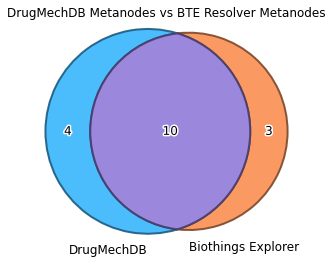

In [12]:
venn2([dmdb_mn, set(metadata.keys())], ('DrugMechDB', 'Biothings Explorer'))
plt.title('DrugMechDB Metanodes vs BTE Resolver Metanodes');

In [13]:
dmdb_mn - set(metadata.keys())

{'GeneFamily',
 'GrossAnatomicalStructure',
 'MacromolecularComplex',
 'OrganismTaxon'}

In [14]:
dmdb_bte_mn_map = {'GrossAnatomicalStructure':'AnatomicalEntity'}

In [15]:
mn_to_quid = {}
for mn in dmdb_mn:
    mn_to_quid[mn] = metadata.get(dmdb_bte_mn_map.get(mn, mn), {}).get('id_ranks', [])

In [16]:
mn_to_quid

{'Drug': ['CHEBI',
  'CHEMBL.COMPOUND',
  'DRUGBANK',
  'PUBCHEM.COMPOUND',
  'MESH',
  'INCHI',
  'INCHIKEY',
  'UNII',
  'KEGG',
  'UMLS',
  'LINCS',
  'name'],
 'GrossAnatomicalStructure': ['UBERON', 'UMLS', 'MESH', 'NCIT', 'name'],
 'MolecularActivity': ['GO', 'MetaCyc', 'RHEA', 'KEGG', 'REACT', 'name'],
 'Disease': ['MONDO',
  'DOID',
  'OMIM',
  'ORPHANET',
  'EFO',
  'UMLS',
  'MESH',
  'HP',
  'GARD',
  'name'],
 'MacromolecularComplex': [],
 'BiologicalProcess': ['GO', 'MetaCyc', 'REACT', 'KEGG', 'name'],
 'Protein': ['UniProtKB', 'ENSEMBL', 'SYMBOL', 'UMLS', 'name'],
 'Cell': ['CL', 'NCIT', 'MESH', 'EFO', 'name'],
 'OrganismTaxon': [],
 'CellularComponent': ['GO', 'MetaCyc', 'RHEA', 'name'],
 'GeneFamily': [],
 'Pathway': ['REACT', 'KEGG', 'PHARMGKB', 'WIKIPATHWAYS', 'name'],
 'PhenotypicFeature': ['UMLS',
  'SNOMEDCT',
  'HP',
  'MEDDRA',
  'EFO',
  'NCIT',
  'MESH',
  'MP',
  'name'],
 'ChemicalSubstance': ['CHEBI',
  'CHEMBL.COMPOUND',
  'DRUGBANK',
  'PUBCHEM.COMPOUND',
 

In [17]:
dmdb_nodes['curi'] = dmdb_nodes['id'].apply(lambda s: s.split(':')[0])
mn_to_curi = dmdb_nodes.groupby('label')['curi'].unique().apply(list).to_dict()

In [18]:
def get_types_for_curi(curi):
    out = []
    for k, v in metadata.items():
        if curi in v['id_ranks']:
            out.append(k)
    return out

In [19]:
get_types_for_curi('MESH')

['ChemicalSubstance',
 'Drug',
 'PhenotypicFeature',
 'Disease',
 'AnatomicalEntity',
 'Cell']

In [20]:
for mn in mn_to_curi.keys():
    print(mn, ':', mn_to_curi[mn])
    print(mn_to_quid[mn], end='\n\n')

BiologicalProcess : ['GO', 'MESH', 'HP', 'REACT']
['GO', 'MetaCyc', 'REACT', 'KEGG', 'name']

Cell : ['CL', 'MESH']
['CL', 'NCIT', 'MESH', 'EFO', 'name']

CellularComponent : ['GO', 'MESH']
['GO', 'MetaCyc', 'RHEA', 'name']

ChemicalSubstance : ['MESH', 'CHEBI', 'GO']
['CHEBI', 'CHEMBL.COMPOUND', 'DRUGBANK', 'PUBCHEM.COMPOUND', 'MESH', 'INCHI', 'INCHIKEY', 'UNII', 'KEGG', 'UMLS', 'name']

Disease : ['MESH', 'HP']
['MONDO', 'DOID', 'OMIM', 'ORPHANET', 'EFO', 'UMLS', 'MESH', 'HP', 'GARD', 'name']

Drug : ['MESH', 'DB', 'CHEBI']
['CHEBI', 'CHEMBL.COMPOUND', 'DRUGBANK', 'PUBCHEM.COMPOUND', 'MESH', 'INCHI', 'INCHIKEY', 'UNII', 'KEGG', 'UMLS', 'LINCS', 'name']

GeneFamily : ['TIGR', 'InterPro', 'MESH', 'Pfam']
[]

GrossAnatomicalStructure : ['UBERON', 'CL', 'MESH', 'GO']
['UBERON', 'UMLS', 'MESH', 'NCIT', 'name']

MacromolecularComplex : ['PR', 'MESH']
[]

MolecularActivity : ['GO']
['GO', 'MetaCyc', 'RHEA', 'KEGG', 'REACT', 'name']

OrganismTaxon : ['NCBITaxon', 'UBERON']
[]

Pathway : ['RE

In [21]:
dmdb_bte_curi_map = {
    'UniProt': 'UniProtKB',
    'DB': 'DRUGBANK',    
}

In [22]:
for mn in mn_to_curi.keys():
    print(mn, ':', set(mn_to_curi[mn]) & set(mn_to_quid[mn]))

BiologicalProcess : {'REACT', 'GO'}
Cell : {'CL', 'MESH'}
CellularComponent : {'GO'}
ChemicalSubstance : {'MESH', 'CHEBI'}
Disease : {'MESH', 'HP'}
Drug : {'MESH', 'CHEBI'}
GeneFamily : set()
GrossAnatomicalStructure : {'UBERON', 'MESH'}
MacromolecularComplex : set()
MolecularActivity : {'GO'}
OrganismTaxon : set()
Pathway : {'REACT'}
PhenotypicFeature : {'MESH', 'HP'}
Protein : set()


In [23]:
bte_curis = set(chain(*[v['id_ranks'] for v in metadata.values()]))
dmdb_curis = set([dmdb_bte_curi_map.get(c, c) for c in dmdb_nodes['curi'].unique()])

dmdb_curis - bte_curis

{'InterPro', 'NCBITaxon', 'PR', 'Pfam', 'TIGR'}

In [24]:
dmdb_nodes.query('label == "MacromolecularComplex"')

,id,name,label,curi
1787,PR:000028445,glycoprotein GPIIb/IIIa complex,MacromolecularComplex,PR
1795,PR:000028445,glycoprotein GPIIb/IIIa complex,MacromolecularComplex,PR
1803,PR:000028445,glycoprotein GPIIb/IIIa complex,MacromolecularComplex,PR
1811,PR:000028445,glycoprotein GPIIb/IIIa complex,MacromolecularComplex,PR
3579,PR:000028445,platelet glycoprotein (GP) IIb/IIIa receptor,MacromolecularComplex,PR
4471,PR:000028799,Tubulin,MacromolecularComplex,PR
6793,MESH:D009093,Mucus,MacromolecularComplex,MESH
9532,PR:000028445,Glycoprotein GPIIb/IIIa complex,MacromolecularComplex,PR
10605,PR:000023855,30S ribosomal subunit,MacromolecularComplex,PR
10610,PR:000023855,30S ribosomal subunit,MacromolecularComplex,PR


### Start getting edges ready to query

In [25]:
def nodes_to_dict(nodes):
    out = {}
    for n in nodes:
        out[n['id']] = {'name': n['name'], 'label': n['label']}
    return out

In [26]:
edge_info = defaultdict(list)

for p in ind:
    nmap = nodes_to_dict(p['nodes'])
    for e in p['links']:
        edge_info['start'].append(e['source'])
        edge_info['end'].append(e['target'])
        edge_info['start_mn'].append(nmap[e['source']]['label'])
        edge_info['end_mn'].append(nmap[e['target']]['label'])
        edge_info['type'].append(e['key'])
        
edge_info = pd.DataFrame(edge_info)

In [27]:
unique_edges = edge_info.drop_duplicates(subset=['start', 'end']).copy()

In [28]:
unique_edges['start_curi'] = unique_edges['start'].apply(lambda s: s.split(':')[0])
unique_edges['start_id'] = unique_edges['start'].apply(lambda s: s.split(':')[1])

unique_edges['end_curi'] = unique_edges['end'].apply(lambda s: s.split(':')[0])
unique_edges['end_id'] = unique_edges['end'].apply(lambda s: s.split(':')[1])

In [29]:
curi_map = {k: k for k in unique_edges[['start_curi', 'end_curi']].stack().unique()}
curi_map = {**curi_map, **dmdb_bte_curi_map}

In [30]:
unique_edges['start_curi'] = unique_edges['start_curi'].map(curi_map)
unique_edges['end_curi'] = unique_edges['end_curi'].map(curi_map)

In [31]:
unique_edges

,start,end,start_mn,end_mn,type,start_curi,start_id,end_curi,end_id
0,MESH:D000068877,UniProt:P00519,Drug,Protein,decreases activity of,MESH,D000068877,UniProtKB,P00519
1,UniProt:P00519,MESH:D015464,Protein,Disease,causes,UniProtKB,P00519,MESH,D015464
2,MESH:D000068877,UniProt:P10721,Drug,Protein,decreases activity of,MESH,D000068877,UniProtKB,P10721
3,MESH:D000068877,UniProt:P16234,Drug,Protein,decreases activity of,MESH,D000068877,UniProtKB,P16234
4,UniProt:P10721,GO:0008283,Protein,BiologicalProcess,positively regulates,UniProtKB,P10721,GO,0008283
...,...,...,...,...,...,...,...,...,...
12319,GO:0006954,MESH:D017439,BiologicalProcess,Disease,correlated with,GO,0006954,MESH,D017439
12320,MESH:C012293,InterPro:IPR015618,Drug,GeneFamily,decreases synthesis of,MESH,C012293,InterPro,IPR015618
12321,InterPro:IPR015618,GO:0032964,GeneFamily,BiologicalProcess,decreases activity of,InterPro,IPR015618,GO,0032964
12322,GO:0032964,CL:0000057,BiologicalProcess,Cell,located in,GO,0032964,CL,0000057


In [32]:
unique_edges['start_in_bte'] = unique_edges['start_curi'].apply(lambda s: s in bte_curis)
unique_edges['end_in_bte'] = unique_edges['end_curi'].apply(lambda s: s in bte_curis)

In [33]:
unique_edges.query('start_in_bte')

,start,end,start_mn,end_mn,type,start_curi,start_id,end_curi,end_id,start_in_bte,end_in_bte
0,MESH:D000068877,UniProt:P00519,Drug,Protein,decreases activity of,MESH,D000068877,UniProtKB,P00519,True,True
1,UniProt:P00519,MESH:D015464,Protein,Disease,causes,UniProtKB,P00519,MESH,D015464,True,True
2,MESH:D000068877,UniProt:P10721,Drug,Protein,decreases activity of,MESH,D000068877,UniProtKB,P10721,True,True
3,MESH:D000068877,UniProt:P16234,Drug,Protein,decreases activity of,MESH,D000068877,UniProtKB,P16234,True,True
4,UniProt:P10721,GO:0008283,Protein,BiologicalProcess,positively regulates,UniProtKB,P10721,GO,0008283,True,True
...,...,...,...,...,...,...,...,...,...,...,...
12312,GO:0048144,MESH:D017439,BiologicalProcess,Disease,correlated with,GO,0048144,MESH,D017439,True,True
12319,GO:0006954,MESH:D017439,BiologicalProcess,Disease,correlated with,GO,0006954,MESH,D017439,True,True
12320,MESH:C012293,InterPro:IPR015618,Drug,GeneFamily,decreases synthesis of,MESH,C012293,InterPro,IPR015618,True,False
12322,GO:0032964,CL:0000057,BiologicalProcess,Cell,located in,GO,0032964,CL,0000057,True,True


In [34]:
unique_edges['start_qid'] = unique_edges['start_curi'] + ':' + unique_edges['start_id']
unique_edges['end_qid'] = unique_edges['end_curi'] + ':' + unique_edges['end_id']

In [35]:
first_queries = unique_edges.query('start_in_bte').groupby('end_mn')['start_qid'].unique().to_dict()

In [36]:
second_queries = unique_edges.query('end_in_bte').groupby('start_mn')['end_qid'].unique().to_dict()

In [37]:
all_queries = {}
for k, v in first_queries.items():
    all_queries[k] = list(set(v) | set(second_queries[k]))

In [38]:
for k, v in all_queries.items():
    print(k, ':  {:,}'.format(len(v)))

BiologicalProcess :  1,646
Cell :  110
CellularComponent :  93
ChemicalSubstance :  625
Disease :  659
Drug :  774
GeneFamily :  294
GrossAnatomicalStructure :  236
MacromolecularComplex :  13
MolecularActivity :  163
OrganismTaxon :  220
Pathway :  170
PhenotypicFeature :  402
Protein :  1,243


# MAP

Protein --> Gene  
Complex/Fam --> Protein

In [39]:
query_data = {
    "message": {
        "query_graph": {
            "nodes": {
                "n0": {
                    "id": ''
                },
                "n1": {
                }
            },
            "edges": {
                "e01": {
                    "subject": "n0",
                    "object": "n1"
                }
            }
        }
    }
}


In [40]:
def chunk_list(list_data, chunk_size):
    for i in range(0, len(list_data), chunk_size): 
        yield list_data[i:i + chunk_size]

In [41]:
{mn: 'biolink:'+mn for mn in edge_info[['start_mn', 'end_mn']].stack().unique()}

{'Drug': 'biolink:Drug',
 'Protein': 'biolink:Protein',
 'Disease': 'biolink:Disease',
 'BiologicalProcess': 'biolink:BiologicalProcess',
 'Pathway': 'biolink:Pathway',
 'ChemicalSubstance': 'biolink:ChemicalSubstance',
 'GrossAnatomicalStructure': 'biolink:GrossAnatomicalStructure',
 'MolecularActivity': 'biolink:MolecularActivity',
 'OrganismTaxon': 'biolink:OrganismTaxon',
 'GeneFamily': 'biolink:GeneFamily',
 'CellularComponent': 'biolink:CellularComponent',
 'PhenotypicFeature': 'biolink:PhenotypicFeature',
 'Cell': 'biolink:Cell',
 'MacromolecularComplex': 'biolink:MacromolecularComplex'}

In [42]:
q_mn_map = {'Drug': ['biolink:Drug', 'biolink:ChemicalSubstance'],
     'Protein': ['biolink:Protein', 'biolink:Gene'],
     'Disease': 'biolink:Disease',
     'BiologicalProcess': 'biolink:BiologicalProcess',
     'Pathway': 'biolink:Pathway',
     'ChemicalSubstance': 'biolink:ChemicalSubstance',
     'GrossAnatomicalStructure': ['biolink:GrossAnatomicalStructure', 'biolink:AnatomicalEntity'],
     'MolecularActivity': 'biolink:MolecularActivity',
     'OrganismTaxon': 'biolink:OrganismTaxon',
     'GeneFamily': ['biolink:GeneFamily', 'biolink:Protein'],
     'CellularComponent': 'biolink:CellularComponent',
     'PhenotypicFeature': 'biolink:PhenotypicFeature',
     'Cell': 'biolink:Cell',
     'MacromolecularComplex': ['biolink:MacromolecularComplex', 'biolink:Protein']}

In [43]:
len(all_queries)

14

In [44]:
# Localhost is running https://github.com/biothings/BioThings_Explorer_TRAPI
URL = 'http://localhost:3000/v1/query'

In [45]:
#URL = "https://api.bte.ncats.io/v1/query"

## Initial Query of BTE

In [53]:
all_queries.keys()

dict_keys(['BiologicalProcess', 'Cell', 'CellularComponent', 'ChemicalSubstance', 'Disease', 'Drug', 'GeneFamily', 'GrossAnatomicalStructure', 'MacromolecularComplex', 'MolecularActivity', 'OrganismTaxon', 'Pathway', 'PhenotypicFeature', 'Protein'])

In [46]:
success = []
fail = []
all_results = []
all_id_mappings = []

for k, v in tqdm(all_queries.items(), desc='outer', total=len(all_queries)):
    query_data['message']['query_graph']['nodes']['n1']['category'] = q_mn_map[k]

    for n in tqdm(chunk_list(v, 10), desc=k, total=len(v)//10):

        try:
            query_data['message']['query_graph']['nodes']['n0']['id'] = n
            r = requests.post(URL, json=query_data)
            all_results.append(process_bte_result(r))
            all_id_mappings.append(get_response_ids(r))
            success.extend(n)
        except:
            time.sleep(10) #sleep on a failure... sometimes the API restarts and
                           # Hundereds of queries can fail in that time perioed
            print("Failed query")
            fail.extend(n)

BiologicalProcess:   5%|▌         | 9/164 [02:17<42:38, 16.51s/it]

Failed query



BiologicalProcess:  30%|██▉       | 49/164 [12:18<33:57, 17.72s/it]

Failed query



BiologicalProcess:  55%|█████▍    | 90/164 [22:19<17:55, 14.54s/it]

Failed query



BiologicalProcess:  80%|████████  | 132/164 [32:20<07:37, 14.29s/it]

Failed query



BiologicalProcess: 100%|██████████| 164/164 [40:09<00:00, 15.90s/it]
BiologicalProcess: 165it [40:25, 14.70s/it]                         
Cell:  73%|███████▎  | 8/11 [01:51<00:41, 13.73s/it]

Failed query



CellularComponent: 100%|██████████| 9/9 [02:01<00:00, 13.25s/it]
CellularComponent: 10it [02:13, 13.33s/it]                      
ChemicalSubstance:  47%|████▋     | 29/62 [07:07<08:23, 15.24s/it]

Failed query



ChemicalSubstance: 100%|██████████| 62/62 [15:45<00:00, 15.03s/it]
ChemicalSubstance: 63it [15:55, 15.16s/it]                        
Disease:   6%|▌         | 4/65 [01:13<18:22, 18.08s/it]

Failed query



Disease:  55%|█████▌    | 36/65 [11:13<07:45, 16.06s/it]

Failed query



Disease: 100%|██████████| 65/65 [20:21<00:00, 20.39s/it]
Disease: 66it [20:45, 18.87s/it]                        
Drug:   3%|▎         | 2/77 [00:27<16:24, 13.13s/it]

Failed query



Drug:   4%|▍         | 3/77 [00:37<14:26, 11.72s/it]

Failed query



Drug:   5%|▌         | 4/77 [00:47<13:26, 11.05s/it]

Failed query



Drug:   6%|▋         | 5/77 [00:57<12:48, 10.67s/it]

Failed query



Drug:   8%|▊         | 6/77 [01:07<12:21, 10.45s/it]

Failed query



Drug:   9%|▉         | 7/77 [01:17<12:01, 10.31s/it]

Failed query



Drug:  10%|█         | 8/77 [01:27<11:44, 10.22s/it]

Failed query



Drug:  12%|█▏        | 9/77 [01:37<11:30, 10.15s/it]

Failed query



Drug:  13%|█▎        | 10/77 [01:47<11:17, 10.11s/it]

Failed query



Drug:  14%|█▍        | 11/77 [01:57<11:05, 10.08s/it]

Failed query



Drug:  16%|█▌        | 12/77 [02:07<10:53, 10.06s/it]

Failed query



Drug:  17%|█▋        | 13/77 [02:17<10:42, 10.05s/it]

Failed query



Drug:  18%|█▊        | 14/77 [02:27<10:32, 10.04s/it]

Failed query



Drug:  19%|█▉        | 15/77 [02:37<10:21, 10.03s/it]

Failed query



Drug:  21%|██        | 16/77 [02:47<10:11, 10.03s/it]

Failed query



Drug:  22%|██▏       | 17/77 [02:57<10:01, 10.02s/it]

Failed query



Drug:  23%|██▎       | 18/77 [03:07<09:51, 10.02s/it]

Failed query



Drug:  25%|██▍       | 19/77 [03:17<09:40, 10.02s/it]

Failed query



Drug:  26%|██▌       | 20/77 [03:27<09:30, 10.02s/it]

Failed query



Drug:  27%|██▋       | 21/77 [03:37<09:20, 10.02s/it]

Failed query



Drug:  29%|██▊       | 22/77 [03:47<09:10, 10.02s/it]

Failed query



Drug:  30%|██▉       | 23/77 [03:57<09:00, 10.02s/it]

Failed query



Drug:  31%|███       | 24/77 [04:07<08:50, 10.02s/it]

Failed query



Drug:  32%|███▏      | 25/77 [04:17<08:40, 10.02s/it]

Failed query



Drug:  34%|███▍      | 26/77 [04:27<08:30, 10.02s/it]

Failed query



Drug:  35%|███▌      | 27/77 [04:37<08:20, 10.02s/it]

Failed query



Drug:  36%|███▋      | 28/77 [04:48<08:10, 10.02s/it]

Failed query



Drug:  38%|███▊      | 29/77 [04:58<08:00, 10.02s/it]

Failed query



Drug:  39%|███▉      | 30/77 [05:08<07:50, 10.01s/it]

Failed query



Drug:  40%|████      | 31/77 [05:18<07:40, 10.02s/it]

Failed query



Drug:  42%|████▏     | 32/77 [05:28<07:30, 10.02s/it]

Failed query



Drug:  43%|████▎     | 33/77 [05:38<07:20, 10.02s/it]

Failed query



Drug:  44%|████▍     | 34/77 [05:48<07:10, 10.01s/it]

Failed query



Drug:  45%|████▌     | 35/77 [05:58<07:00, 10.01s/it]

Failed query



Drug:  47%|████▋     | 36/77 [06:08<06:50, 10.02s/it]

Failed query



Drug:  48%|████▊     | 37/77 [06:18<06:40, 10.02s/it]

Failed query



Drug:  49%|████▉     | 38/77 [06:28<06:30, 10.02s/it]

Failed query



Drug:  51%|█████     | 39/77 [06:38<06:20, 10.02s/it]

Failed query



Drug:  52%|█████▏    | 40/77 [06:48<06:10, 10.02s/it]

Failed query



Drug:  53%|█████▎    | 41/77 [06:58<06:00, 10.02s/it]

Failed query



Drug:  55%|█████▍    | 42/77 [07:08<05:50, 10.02s/it]

Failed query



Drug:  56%|█████▌    | 43/77 [07:18<05:40, 10.01s/it]

Failed query



Drug:  57%|█████▋    | 44/77 [07:28<05:30, 10.02s/it]

Failed query



Drug:  58%|█████▊    | 45/77 [07:38<05:20, 10.02s/it]

Failed query



Drug:  60%|█████▉    | 46/77 [07:48<05:10, 10.02s/it]

Failed query



Drug:  61%|██████    | 47/77 [07:58<05:00, 10.02s/it]

Failed query



Drug:  62%|██████▏   | 48/77 [08:08<04:50, 10.02s/it]

Failed query



Drug:  64%|██████▎   | 49/77 [08:18<04:40, 10.02s/it]

Failed query



Drug:  65%|██████▍   | 50/77 [08:28<04:30, 10.02s/it]

Failed query



Drug:  66%|██████▌   | 51/77 [08:38<04:20, 10.02s/it]

Failed query



Drug:  68%|██████▊   | 52/77 [08:48<04:10, 10.02s/it]

Failed query



Drug:  69%|██████▉   | 53/77 [08:58<04:00, 10.02s/it]

Failed query



Drug:  70%|███████   | 54/77 [09:08<03:50, 10.02s/it]

Failed query



Drug:  71%|███████▏  | 55/77 [09:18<03:40, 10.02s/it]

Failed query



Drug:  73%|███████▎  | 56/77 [09:28<03:30, 10.02s/it]

Failed query



Drug:  74%|███████▍  | 57/77 [09:38<03:20, 10.02s/it]

Failed query



Drug:  75%|███████▌  | 58/77 [09:48<03:10, 10.02s/it]

Failed query



Drug:  77%|███████▋  | 59/77 [09:58<03:00, 10.02s/it]

Failed query



Drug:  78%|███████▊  | 60/77 [10:08<02:50, 10.02s/it]

Failed query



Drug:  79%|███████▉  | 61/77 [10:18<02:40, 10.01s/it]

Failed query



Drug:  81%|████████  | 62/77 [10:28<02:30, 10.01s/it]

Failed query



Drug:  82%|████████▏ | 63/77 [10:38<02:20, 10.02s/it]

Failed query



Drug:  83%|████████▎ | 64/77 [10:48<02:10, 10.02s/it]

Failed query



Drug:  84%|████████▍ | 65/77 [10:58<02:00, 10.02s/it]

Failed query



Drug:  86%|████████▌ | 66/77 [11:08<01:50, 10.02s/it]

Failed query



Drug:  87%|████████▋ | 67/77 [11:18<01:40, 10.02s/it]

Failed query



Drug:  88%|████████▊ | 68/77 [11:28<01:30, 10.02s/it]

Failed query



Drug:  90%|████████▉ | 69/77 [11:38<01:20, 10.02s/it]

Failed query



Drug:  91%|█████████ | 70/77 [11:48<01:10, 10.02s/it]

Failed query



Drug:  92%|█████████▏| 71/77 [11:58<01:00, 10.02s/it]

Failed query



Drug:  94%|█████████▎| 72/77 [12:08<00:50, 10.02s/it]

Failed query



Drug:  95%|█████████▍| 73/77 [12:18<00:40, 10.02s/it]

Failed query



Drug:  96%|█████████▌| 74/77 [12:28<00:30, 10.02s/it]

Failed query



Drug:  97%|█████████▋| 75/77 [12:38<00:20, 10.02s/it]

Failed query



Drug:  99%|█████████▊| 76/77 [12:48<00:10, 10.01s/it]

Failed query



Drug: 100%|██████████| 77/77 [12:58<00:00, 10.01s/it]

Failed query



Drug: 78it [13:08, 10.11s/it]                        
GeneFamily:   0%|          | 0/29 [00:00<?, ?it/s]

Failed query



GeneFamily:   3%|▎         | 1/29 [00:10<04:40, 10.01s/it]

Failed query



GeneFamily:   7%|▋         | 2/29 [00:20<04:30, 10.02s/it]

Failed query



GeneFamily:  10%|█         | 3/29 [00:30<04:20, 10.01s/it]

Failed query



GeneFamily:  14%|█▍        | 4/29 [00:40<04:10, 10.01s/it]

Failed query



GeneFamily:  17%|█▋        | 5/29 [00:50<04:00, 10.02s/it]

Failed query



GeneFamily:  21%|██        | 6/29 [01:00<03:50, 10.01s/it]

Failed query



GeneFamily:  24%|██▍       | 7/29 [01:10<03:40, 10.01s/it]

Failed query



GeneFamily:  28%|██▊       | 8/29 [01:20<03:30, 10.01s/it]

Failed query



GeneFamily:  31%|███       | 9/29 [01:30<03:20, 10.01s/it]

Failed query



GeneFamily:  34%|███▍      | 10/29 [01:40<03:10, 10.02s/it]

Failed query



GeneFamily:  38%|███▊      | 11/29 [01:50<03:00, 10.02s/it]

Failed query



GeneFamily:  41%|████▏     | 12/29 [02:00<02:50, 10.02s/it]

Failed query



GeneFamily:  45%|████▍     | 13/29 [02:10<02:40, 10.02s/it]

Failed query



GeneFamily:  48%|████▊     | 14/29 [02:20<02:30, 10.02s/it]

Failed query



GeneFamily:  52%|█████▏    | 15/29 [02:30<02:20, 10.02s/it]

Failed query



GeneFamily:  55%|█████▌    | 16/29 [02:40<02:10, 10.02s/it]

Failed query



GeneFamily:  59%|█████▊    | 17/29 [02:50<02:00, 10.02s/it]

Failed query



GeneFamily:  62%|██████▏   | 18/29 [03:00<01:50, 10.02s/it]

Failed query



GeneFamily:  66%|██████▌   | 19/29 [03:10<01:40, 10.02s/it]

Failed query



GeneFamily:  69%|██████▉   | 20/29 [03:20<01:30, 10.02s/it]

Failed query



GeneFamily:  72%|███████▏  | 21/29 [03:30<01:20, 10.02s/it]

Failed query



GeneFamily:  76%|███████▌  | 22/29 [03:40<01:10, 10.02s/it]

Failed query



GeneFamily:  79%|███████▉  | 23/29 [03:50<01:00, 10.02s/it]

Failed query



GeneFamily:  83%|████████▎ | 24/29 [04:00<00:50, 10.02s/it]

Failed query



GeneFamily:  86%|████████▌ | 25/29 [04:10<00:40, 10.02s/it]

Failed query



GeneFamily:  90%|████████▉ | 26/29 [04:20<00:30, 10.02s/it]

Failed query



GeneFamily:  93%|█████████▎| 27/29 [04:30<00:20, 10.02s/it]

Failed query



GeneFamily:  97%|█████████▋| 28/29 [04:40<00:10, 10.02s/it]

Failed query



GeneFamily: 100%|██████████| 29/29 [04:50<00:00, 10.02s/it]

Failed query



GeneFamily: 30it [05:00, 10.02s/it]                        
GrossAnatomicalStructure:   0%|          | 0/23 [00:00<?, ?it/s]

Failed query



GrossAnatomicalStructure:   4%|▍         | 1/23 [00:10<03:40, 10.01s/it]

Failed query



GrossAnatomicalStructure:   9%|▊         | 2/23 [00:20<03:30, 10.01s/it]

Failed query



GrossAnatomicalStructure:  13%|█▎        | 3/23 [00:30<03:20, 10.01s/it]

Failed query



GrossAnatomicalStructure:  17%|█▋        | 4/23 [00:40<03:10, 10.02s/it]

Failed query



GrossAnatomicalStructure:  22%|██▏       | 5/23 [00:50<03:00, 10.02s/it]

Failed query



GrossAnatomicalStructure:  26%|██▌       | 6/23 [01:00<02:50, 10.02s/it]

Failed query



GrossAnatomicalStructure:  30%|███       | 7/23 [01:10<02:40, 10.02s/it]

Failed query



GrossAnatomicalStructure:  35%|███▍      | 8/23 [01:20<02:30, 10.02s/it]

Failed query



GrossAnatomicalStructure:  39%|███▉      | 9/23 [01:30<02:20, 10.02s/it]

Failed query



GrossAnatomicalStructure:  43%|████▎     | 10/23 [01:40<02:10, 10.02s/it]

Failed query



GrossAnatomicalStructure:  48%|████▊     | 11/23 [01:50<02:00, 10.02s/it]

Failed query



GrossAnatomicalStructure:  52%|█████▏    | 12/23 [02:00<01:50, 10.02s/it]

Failed query



GrossAnatomicalStructure:  57%|█████▋    | 13/23 [02:10<01:40, 10.02s/it]

Failed query



GrossAnatomicalStructure:  61%|██████    | 14/23 [02:20<01:30, 10.02s/it]

Failed query



GrossAnatomicalStructure:  65%|██████▌   | 15/23 [02:30<01:20, 10.02s/it]

Failed query



GrossAnatomicalStructure:  70%|██████▉   | 16/23 [02:40<01:10, 10.02s/it]

Failed query



GrossAnatomicalStructure:  74%|███████▍  | 17/23 [02:50<01:00, 10.02s/it]

Failed query



GrossAnatomicalStructure:  78%|███████▊  | 18/23 [03:00<00:50, 10.02s/it]

Failed query



GrossAnatomicalStructure:  83%|████████▎ | 19/23 [03:10<00:40, 10.02s/it]

Failed query



GrossAnatomicalStructure:  87%|████████▋ | 20/23 [03:20<00:30, 10.02s/it]

Failed query



GrossAnatomicalStructure:  91%|█████████▏| 21/23 [03:30<00:20, 10.02s/it]

Failed query



GrossAnatomicalStructure:  96%|█████████▌| 22/23 [03:40<00:10, 10.02s/it]

Failed query



GrossAnatomicalStructure: 100%|██████████| 23/23 [03:50<00:00, 10.02s/it]

Failed query



GrossAnatomicalStructure: 24it [04:00, 10.02s/it]                        
MacromolecularComplex:   0%|          | 0/1 [00:00<?, ?it/s]

Failed query



MacromolecularComplex: 100%|██████████| 1/1 [00:10<00:00, 10.01s/it]

Failed query



MacromolecularComplex: 2it [00:20, 10.02s/it]                       
MolecularActivity:   0%|          | 0/16 [00:00<?, ?it/s]

Failed query



MolecularActivity:   6%|▋         | 1/16 [00:10<02:30, 10.01s/it]

Failed query



MolecularActivity:  12%|█▎        | 2/16 [00:20<02:20, 10.02s/it]

Failed query



MolecularActivity:  19%|█▉        | 3/16 [00:30<02:10, 10.02s/it]

Failed query



MolecularActivity:  25%|██▌       | 4/16 [00:40<02:00, 10.02s/it]

Failed query



MolecularActivity:  31%|███▏      | 5/16 [00:50<01:50, 10.02s/it]

Failed query



MolecularActivity:  38%|███▊      | 6/16 [01:00<01:40, 10.02s/it]

Failed query



MolecularActivity:  44%|████▍     | 7/16 [01:10<01:30, 10.02s/it]

Failed query



MolecularActivity:  50%|█████     | 8/16 [01:20<01:20, 10.01s/it]

Failed query



MolecularActivity:  56%|█████▋    | 9/16 [01:30<01:10, 10.01s/it]

Failed query



MolecularActivity:  62%|██████▎   | 10/16 [01:40<01:00, 10.01s/it]

Failed query



MolecularActivity:  69%|██████▉   | 11/16 [01:50<00:50, 10.02s/it]

Failed query



MolecularActivity:  75%|███████▌  | 12/16 [02:00<00:40, 10.02s/it]

Failed query



MolecularActivity:  81%|████████▏ | 13/16 [02:10<00:30, 10.02s/it]

Failed query



MolecularActivity:  88%|████████▊ | 14/16 [02:20<00:20, 10.02s/it]

Failed query



MolecularActivity:  94%|█████████▍| 15/16 [02:30<00:10, 10.02s/it]

Failed query



MolecularActivity: 100%|██████████| 16/16 [02:40<00:00, 10.02s/it]

Failed query



MolecularActivity: 17it [02:50, 10.01s/it]                        
OrganismTaxon:   0%|          | 0/22 [00:00<?, ?it/s]

Failed query



OrganismTaxon:   5%|▍         | 1/22 [00:10<03:30, 10.01s/it]

Failed query



OrganismTaxon:   9%|▉         | 2/22 [00:20<03:20, 10.02s/it]

Failed query



OrganismTaxon:  14%|█▎        | 3/22 [00:30<03:10, 10.02s/it]

Failed query



OrganismTaxon:  18%|█▊        | 4/22 [00:40<03:00, 10.02s/it]

Failed query



OrganismTaxon:  23%|██▎       | 5/22 [00:50<02:50, 10.02s/it]

Failed query



OrganismTaxon:  27%|██▋       | 6/22 [01:00<02:40, 10.02s/it]

Failed query



OrganismTaxon:  32%|███▏      | 7/22 [01:10<02:30, 10.02s/it]

Failed query



OrganismTaxon:  36%|███▋      | 8/22 [01:20<02:20, 10.02s/it]

Failed query



OrganismTaxon:  41%|████      | 9/22 [01:30<02:10, 10.02s/it]

Failed query



OrganismTaxon:  45%|████▌     | 10/22 [01:40<02:00, 10.02s/it]

Failed query



OrganismTaxon:  50%|█████     | 11/22 [01:50<01:50, 10.02s/it]

Failed query



OrganismTaxon:  55%|█████▍    | 12/22 [02:00<01:40, 10.02s/it]

Failed query



OrganismTaxon:  59%|█████▉    | 13/22 [02:10<01:30, 10.02s/it]

Failed query



OrganismTaxon:  64%|██████▎   | 14/22 [02:20<01:20, 10.02s/it]

Failed query



OrganismTaxon:  68%|██████▊   | 15/22 [02:30<01:10, 10.02s/it]

Failed query



OrganismTaxon:  73%|███████▎  | 16/22 [02:40<01:00, 10.02s/it]

Failed query



OrganismTaxon:  77%|███████▋  | 17/22 [02:50<00:50, 10.02s/it]

Failed query



OrganismTaxon:  82%|████████▏ | 18/22 [03:00<00:40, 10.02s/it]

Failed query



OrganismTaxon:  86%|████████▋ | 19/22 [03:10<00:30, 10.02s/it]

Failed query



OrganismTaxon:  91%|█████████ | 20/22 [03:20<00:20, 10.02s/it]

Failed query



OrganismTaxon:  95%|█████████▌| 21/22 [03:30<00:10, 10.02s/it]

Failed query



Pathway:   0%|          | 0/17 [00:00<?, ?it/s]

Failed query



Pathway:   6%|▌         | 1/17 [00:10<02:40, 10.01s/it]

Failed query



Pathway:  12%|█▏        | 2/17 [00:20<02:30, 10.01s/it]

Failed query



Pathway:  18%|█▊        | 3/17 [00:30<02:20, 10.01s/it]

Failed query



Pathway:  24%|██▎       | 4/17 [00:40<02:10, 10.01s/it]

Failed query



Pathway:  29%|██▉       | 5/17 [00:50<02:00, 10.01s/it]

Failed query



Pathway:  35%|███▌      | 6/17 [01:00<01:50, 10.01s/it]

Failed query



Pathway:  41%|████      | 7/17 [01:10<01:40, 10.01s/it]

Failed query



Pathway:  47%|████▋     | 8/17 [01:20<01:30, 10.01s/it]

Failed query



Pathway:  53%|█████▎    | 9/17 [01:30<01:20, 10.02s/it]

Failed query



Pathway:  59%|█████▉    | 10/17 [01:40<01:10, 10.02s/it]

Failed query



Pathway:  65%|██████▍   | 11/17 [01:50<01:00, 10.02s/it]

Failed query



Pathway:  71%|███████   | 12/17 [02:00<00:50, 10.02s/it]

Failed query



Pathway:  76%|███████▋  | 13/17 [02:10<00:40, 10.02s/it]

Failed query



Pathway:  82%|████████▏ | 14/17 [02:20<00:30, 10.02s/it]

Failed query



Pathway:  88%|████████▊ | 15/17 [02:30<00:20, 10.02s/it]

Failed query



Pathway:  94%|█████████▍| 16/17 [02:40<00:10, 10.02s/it]

Failed query



PhenotypicFeature:   0%|          | 0/40 [00:00<?, ?it/s]

Failed query



PhenotypicFeature:   2%|▎         | 1/40 [00:10<06:30, 10.02s/it]

Failed query



PhenotypicFeature:   5%|▌         | 2/40 [00:20<06:20, 10.01s/it]

Failed query



PhenotypicFeature:   8%|▊         | 3/40 [00:30<06:10, 10.01s/it]

Failed query



PhenotypicFeature:  10%|█         | 4/40 [00:40<06:00, 10.01s/it]

Failed query



PhenotypicFeature:  12%|█▎        | 5/40 [00:50<05:50, 10.01s/it]

Failed query



PhenotypicFeature:  15%|█▌        | 6/40 [01:00<05:40, 10.01s/it]

Failed query



PhenotypicFeature:  18%|█▊        | 7/40 [01:10<05:30, 10.01s/it]

Failed query



PhenotypicFeature:  20%|██        | 8/40 [01:20<05:20, 10.02s/it]

Failed query



PhenotypicFeature:  22%|██▎       | 9/40 [01:30<05:10, 10.02s/it]

Failed query



PhenotypicFeature:  25%|██▌       | 10/40 [01:40<05:00, 10.02s/it]

Failed query



PhenotypicFeature:  28%|██▊       | 11/40 [01:50<04:50, 10.02s/it]

Failed query



PhenotypicFeature:  30%|███       | 12/40 [02:00<04:40, 10.02s/it]

Failed query



PhenotypicFeature:  32%|███▎      | 13/40 [02:10<04:30, 10.02s/it]

Failed query



PhenotypicFeature:  35%|███▌      | 14/40 [02:20<04:20, 10.02s/it]

Failed query



PhenotypicFeature:  38%|███▊      | 15/40 [02:30<04:10, 10.02s/it]

Failed query



PhenotypicFeature:  40%|████      | 16/40 [02:40<04:00, 10.02s/it]

Failed query



PhenotypicFeature:  42%|████▎     | 17/40 [02:50<03:50, 10.02s/it]

Failed query



PhenotypicFeature:  45%|████▌     | 18/40 [03:00<03:40, 10.02s/it]

Failed query



PhenotypicFeature:  48%|████▊     | 19/40 [03:10<03:30, 10.02s/it]

Failed query



PhenotypicFeature:  50%|█████     | 20/40 [03:20<03:20, 10.02s/it]

Failed query



PhenotypicFeature:  52%|█████▎    | 21/40 [03:30<03:10, 10.02s/it]

Failed query



PhenotypicFeature:  55%|█████▌    | 22/40 [03:40<03:00, 10.02s/it]

Failed query



PhenotypicFeature:  57%|█████▊    | 23/40 [03:50<02:50, 10.02s/it]

Failed query



PhenotypicFeature:  60%|██████    | 24/40 [04:00<02:40, 10.01s/it]

Failed query



PhenotypicFeature:  62%|██████▎   | 25/40 [04:10<02:30, 10.01s/it]

Failed query



PhenotypicFeature:  65%|██████▌   | 26/40 [04:20<02:20, 10.01s/it]

Failed query



PhenotypicFeature:  68%|██████▊   | 27/40 [04:30<02:10, 10.01s/it]

Failed query



PhenotypicFeature:  70%|███████   | 28/40 [04:40<02:00, 10.01s/it]

Failed query



PhenotypicFeature:  72%|███████▎  | 29/40 [04:50<01:50, 10.01s/it]

Failed query



PhenotypicFeature:  75%|███████▌  | 30/40 [05:00<01:40, 10.01s/it]

Failed query



PhenotypicFeature:  78%|███████▊  | 31/40 [05:10<01:30, 10.01s/it]

Failed query



PhenotypicFeature:  80%|████████  | 32/40 [05:20<01:20, 10.02s/it]

Failed query



PhenotypicFeature:  82%|████████▎ | 33/40 [05:30<01:10, 10.02s/it]

Failed query



PhenotypicFeature:  85%|████████▌ | 34/40 [05:40<01:00, 10.02s/it]

Failed query



PhenotypicFeature:  88%|████████▊ | 35/40 [05:50<00:50, 10.02s/it]

Failed query



PhenotypicFeature:  90%|█████████ | 36/40 [06:00<00:40, 10.01s/it]

Failed query



PhenotypicFeature:  92%|█████████▎| 37/40 [06:10<00:30, 10.02s/it]

Failed query



PhenotypicFeature:  95%|█████████▌| 38/40 [06:20<00:20, 10.02s/it]

Failed query



PhenotypicFeature:  98%|█████████▊| 39/40 [06:30<00:10, 10.02s/it]

Failed query



PhenotypicFeature: 100%|██████████| 40/40 [06:40<00:00, 10.01s/it]

Failed query



PhenotypicFeature: 41it [06:50, 10.02s/it]                        
Protein:   0%|          | 0/124 [00:00<?, ?it/s]

Failed query



Protein:   1%|          | 1/124 [00:10<20:31, 10.01s/it]

Failed query



Protein:   2%|▏         | 2/124 [00:20<20:21, 10.02s/it]

Failed query



Protein:   2%|▏         | 3/124 [00:30<20:11, 10.02s/it]

Failed query



Protein:   3%|▎         | 4/124 [00:40<20:01, 10.02s/it]

Failed query


outer:  93%|█████████▎| 13/14 [2:01:15<09:19, 559.63s/it]


KeyboardInterrupt: 

In [47]:
len(success)

3063

In [48]:
len(fail)

2382

In [49]:
len(pd.concat(all_results))

570444

In [50]:
pd.concat(all_results).drop_duplicates().to_csv(out_dir.joinpath('BTE_TRAPI_result.csv'), index=False)
pd.concat(all_id_mappings).drop_duplicates().to_csv(out_dir.joinpath('BTE_id_maps.csv'), index=False)
pd.Series(success, name='dmdb_identifier').to_csv(out_dir.joinpath('successfully_queried.csv'), index=False)

## Re-query those that previously failed...

In [73]:
finished = ['BiologicalProcess', 'Cell', 'CellularComponent', 'ChemicalSubstance', 'Disease',
           'Drug', 'GeneFamily', 'GrossAnatomicalStructure', 'MacromolecularComplex',
           'MolecularActivity', 'OrganismTaxon', 'Pathway', 'PhenotypicFeature']

In [45]:
URL = 'https://api.bte.ncats.io/v1/query'

In [46]:
URL = 'http://localhost:3000/v1/query'

In [78]:
prev_success = set(pd.read_csv(out_dir.joinpath('successfully_queried.csv'))['dmdb_identifier'])
all_query_ids = set(chain(*[v for v in all_queries.values()]))

fail = all_query_ids - prev_success

In [79]:
prev_success = prev_success | set(success)

In [55]:
type(all_queries[finished[0]])

list

In [80]:
remain_queries = dict()
for k, v in all_queries.items():
    if k in finished:
        remain_queries[k] = list(set(v) - prev_success)
    else:
        remain_queries[k] = v

In [81]:
fail = list(fail)

In [82]:
success = []
new_results = []


for k, v in tqdm(remain_queries.items(), desc='outer', total=len(all_queries)):
    query_data['message']['query_graph']['nodes']['n1']['category'] = q_mn_map[k]

    for n in tqdm(chunk_list(v, 10), desc=k, total=len(v)//10):

        try:
            query_data['message']['query_graph']['nodes']['n0']['id'] = n
            r = requests.post(URL, json=query_data)
            all_results.append(process_bte_result(r))
            all_id_mappings.append(get_response_ids(r))
            success.extend(n)
        except:
            time.sleep(10) #sleep on a failure... sometimes the API restarts and
                           # Hundereds of queries can fail in that time perioed
            print("Failed query")
            fail.extend(n)

outer:   0%|          | 0/14 [00:00<?, ?it/s]
BiologicalProcess: 0it [00:00, ?it/s]

Cell: 0it [00:00, ?it/s]

CellularComponent: 0it [00:00, ?it/s]

ChemicalSubstance: 0it [00:00, ?it/s]

Disease: 0it [00:00, ?it/s]

Drug: 0it [00:00, ?it/s]
Drug: 1it [00:12, 12.55s/it]
outer:  43%|████▎     | 6/14 [00:12<00:16,  2.09s/it]
GeneFamily: 0it [00:00, ?it/s]

GrossAnatomicalStructure: 0it [00:00, ?it/s]

MacromolecularComplex: 0it [00:00, ?it/s]

MolecularActivity: 100%|██████████| 16/16 [02:52<00:00, 10.93s/it]
MolecularActivity: 17it [03:03, 10.78s/it]                        
PhenotypicFeature:  25%|██▌       | 10/40 [02:35<07:16, 14.54s/it]

Failed query



PhenotypicFeature: 100%|██████████| 40/40 [10:09<00:00, 14.87s/it]
PhenotypicFeature: 41it [10:19, 15.11s/it]                        
Protein:  10%|█         | 13/124 [02:15<19:20, 10.46s/it]

Failed query



Protein:  58%|█████▊    | 72/124 [12:12<09:59, 11.53s/it]

Failed query



Protein: 100%|██████████| 124/124 [21:36<00:00, 10.95s/it]
Protein: 125it [21:42, 10.42s/it]                         
outer: 100%|██████████| 14/14 [39:30<00:00, 169.30s/it]


In [84]:
pd.concat(all_results+new_results).drop_duplicates().to_csv(out_dir.joinpath('BTE_TRAPI_result.csv'), index=False)
pd.concat(all_id_mappings).drop_duplicates().to_csv(out_dir.joinpath('BTE_id_maps.csv'), index=False)
pd.Series(list(prev_success)+success, name='dmdb_identifier').to_csv(out_dir.joinpath('successfully_queried.csv'), index=False)

In [83]:
len(pd.concat(all_results+new_results))

1186984

In [65]:
len(list(prev_success)+success)

3519

In [85]:
len(pd.concat(all_results).drop_duplicates())

957669

In [86]:
len(pd.concat(all_id_mappings).drop_duplicates())

494905